In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
"""
Data Folder for YOLOv5 tests
"""
data_folder = "./data-yolo"


### Get Data

In [3]:
def filter_images_with_labels(image_files, data_folder):
    """Filters image files to include only those with corresponding label files."""
    valid_images = []
    for img_file in image_files:
        label_file = img_file.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(data_folder, label_file)):
            valid_images.append((img_file, label_file))
    return valid_images

image_files = [f for f in os.listdir(data_folder) if f.endswith(".jpg")]
filtered_images = filter_images_with_labels(image_files, data_folder)

### Data Analysis

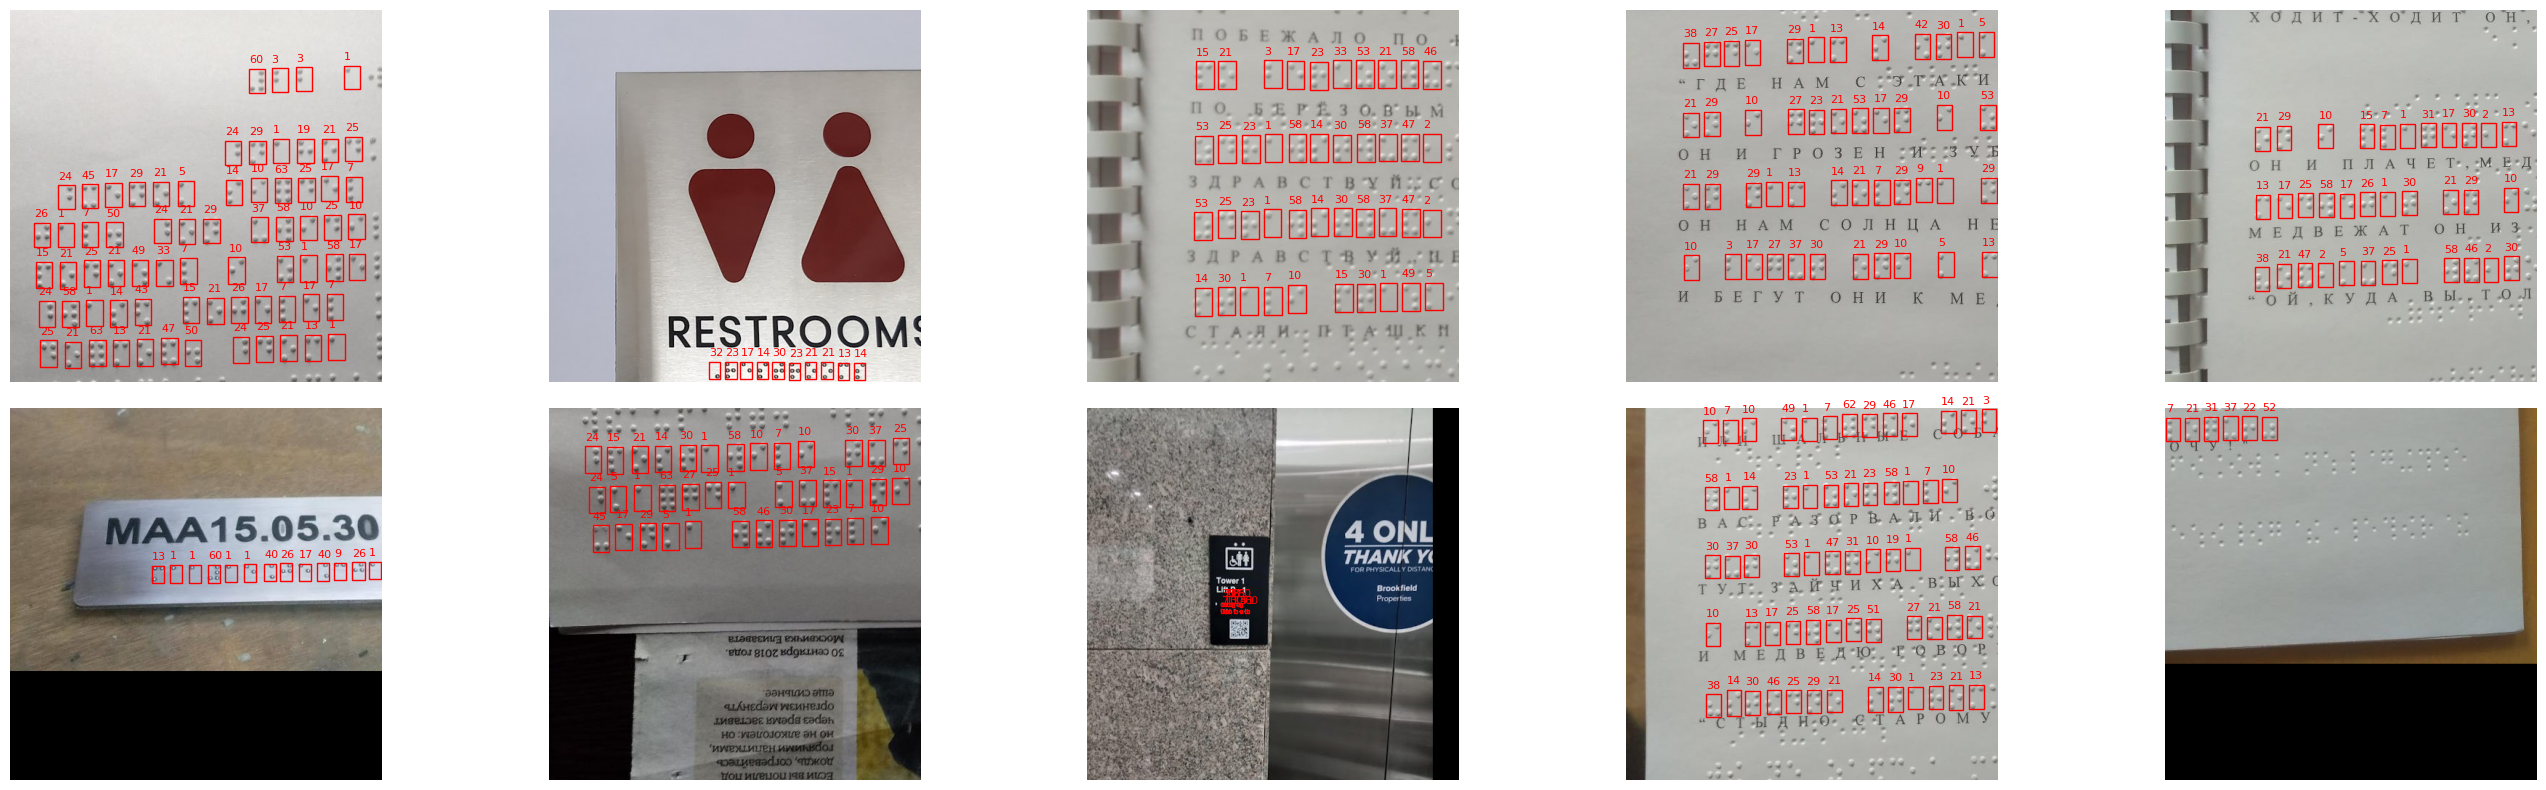

In [4]:
random_images = random.sample(filtered_images, min(10, len(filtered_images)))

def plot_annotated_images(image_files):
    fig, axs = plt.subplots(2, 5, figsize=(28, 8))
    axs = axs.flatten()

    for idx, (img_file, lbl_file) in enumerate(image_files):
        img_path = os.path.join(data_folder, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape
        
        with open(os.path.join(data_folder, lbl_file), "r") as f:
            boxes = f.readlines()
        
        axs[idx].imshow(img)
        for box in boxes:
            class_id, x_center, y_center, box_width, box_height = map(float, box.strip().split())
            x_center *= width
            y_center *= height
            box_width *= width
            box_height *= height
            x_min = x_center - box_width / 2
            y_min = y_center - box_height / 2
            
            axs[idx].add_patch(plt.Rectangle((x_min, y_min), box_width, box_height, edgecolor='red', facecolor='none'))
            axs[idx].text(x_min, y_min - 5, f"{int(class_id) + 1}", color='red', fontsize=8, verticalalignment='bottom')

        axs[idx].axis("off")

    for j in range(idx + 1, 10):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_annotated_images(random_images)


In [5]:
freq_label = {}

for idx, (_, lbl_file) in enumerate(filtered_images):
    with open(os.path.join(data_folder, lbl_file), 'r') as label:
        labels = label.readlines()
        
    labels = [int(l.strip().split()[0]) for l in labels]
    for label in labels:
        if label in freq_label:
            freq_label[label] += 1
        else:
            freq_label[label] = 1

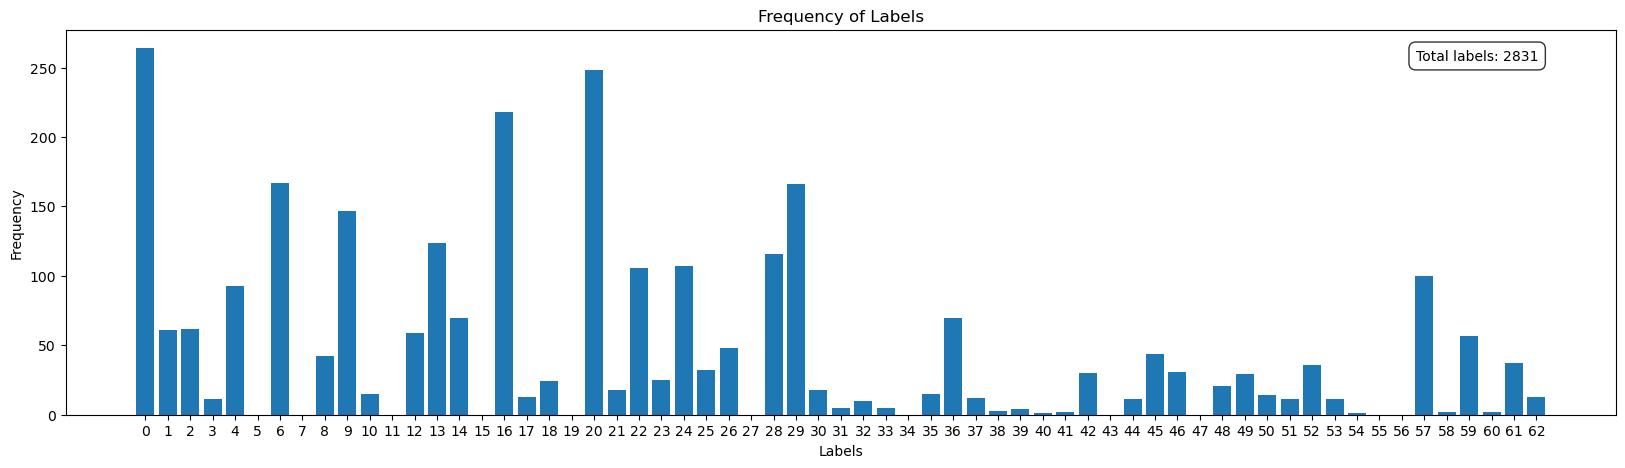

In [6]:
from typing import Dict

def plot_freq_map(freq_map:Dict, x_label:str='Labels', y_label:str='Frequency', title:str='Frequency of Labels'):
    keys = sorted(freq_map.keys())
    values = [freq_map[key] for key in keys]
    total = sum(values)
    
    plt.figure(figsize=(20, 5))
    plt.bar(keys, values)
    plt.xticks(range(min(keys), max(keys) + 1))
    plt.gca().text(0.95, 0.95, f'Total labels: {total}', ha='right', va='top', transform=plt.gca().transAxes,
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    plt.show()

plot_freq_map(freq_map=freq_label)

### YOLOv5 Only

<img src="yolov5-model-structure.avif" alt="YOLOv5 Model Structure" width="50%">

train, test, validation split: 60, 20, 20

In [7]:
from ultralytics import YOLO
import shutil
from sklearn.model_selection import train_test_split

NUM_EPOCHS_YOLO = 80
BATCH_SIZE_YOLO = 18

yolo_data_folder = './yolo-data'
os.makedirs(yolo_data_folder, exist_ok=True)

model = YOLO('yolov5s.pt')

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [8]:
train_images, temp_images = train_test_split(filtered_images, test_size=0.4, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

os.makedirs(os.path.join(yolo_data_folder, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'val', 'labels'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'test', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'test', 'labels'), exist_ok=True)

for img_file, label_file in train_images:
    shutil.copy(os.path.join(data_folder, img_file), os.path.join(yolo_data_folder, 'train', 'images'))
    shutil.copy(os.path.join(data_folder, label_file), os.path.join(yolo_data_folder, 'train', 'labels'))

for img_file, label_file in val_images:
    shutil.copy(os.path.join(data_folder, img_file), os.path.join(yolo_data_folder, 'val', 'images'))
    shutil.copy(os.path.join(data_folder, label_file), os.path.join(yolo_data_folder, 'val', 'labels'))

for img_file, label_file in test_images:
    shutil.copy(os.path.join(data_folder, img_file), os.path.join(yolo_data_folder, 'test', 'images'))
    shutil.copy(os.path.join(data_folder, label_file), os.path.join(yolo_data_folder, 'test', 'labels'))

In [9]:
if os.path.exists('./runs'):
    shutil.rmtree('./runs')
history = model.train(data='yolo.yaml', epochs=NUM_EPOCHS_YOLO, batch=BATCH_SIZE_YOLO)

Ultralytics 8.3.28 🚀 Python-3.12.2 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=yolo.yaml, epochs=80, time=None, patience=100, batch=18, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /home/zeenx1popos/Documents/codes/fyb/yolo-data/train/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/home/zeenx1popos/.conda/envs/fybp/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /home/zeenx1popos/Documents/codes/fyb/yolo-data/val/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000149, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005625000000000001), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      4.67G        3.3      6.404      2.002         75        640: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         19        562          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      5.66G      3.089      5.784      1.822        111        640: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         19        562          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      5.07G      3.115      5.811      1.778         52        640: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

                   all         19        562   0.000324    0.00472   0.000187   5.77e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      5.27G       3.02       5.62      1.684        254        640: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         19        562   0.000331    0.00766   0.000206   0.000108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      4.92G      2.704      5.265      1.535        166        640: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         19        562    0.00085     0.0144   0.000772    0.00032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      5.21G      2.447      5.067      1.387        102        640: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         19        562    0.00263      0.026    0.00204   0.000667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      4.96G      2.397      5.024      1.428         29        640: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         19        562    0.00285     0.0379    0.00315    0.00141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80         5G      2.183      4.875      1.327         29        640: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         19        562      0.415      0.046    0.00565    0.00329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      5.47G      1.989      4.408      1.256         47        640: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         19        562      0.508     0.0586      0.013    0.00934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      5.48G       1.92      4.164      1.205         59        640: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         19        562      0.282      0.116     0.0145    0.00931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      4.76G      1.746      3.899      1.122        100        640: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         19        562      0.355      0.116     0.0195     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      5.39G      1.647      3.669      1.069         75        640: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         19        562      0.317       0.17     0.0281     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      5.18G      1.579      3.579      1.051         71        640: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         19        562      0.511      0.169     0.0373     0.0253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      4.91G      1.738      3.493      1.067        166        640: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         19        562      0.476      0.173     0.0531     0.0372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      4.86G      1.574      3.292      1.077         29        640: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         19        562      0.491      0.157     0.0649     0.0464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      4.98G       1.41      3.051      1.012         47        640: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         19        562      0.558      0.157     0.0841     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80       5.1G      1.409      3.011     0.9718         53        640: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         19        562      0.552      0.156     0.0946     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      5.04G      1.317      2.925     0.9916         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         19        562      0.548      0.154      0.106     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      5.29G      1.383      2.909     0.9772        111        640: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         19        562       0.58      0.181      0.117     0.0872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      5.36G      1.318      2.747      1.002         60        640: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         19        562      0.458      0.246      0.129     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      5.41G      1.329      2.672     0.9748         47        640: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         19        562      0.424      0.259      0.129     0.0958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      5.46G      1.614      2.952      1.015        221        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         19        562      0.532      0.242      0.139      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      5.35G      1.205      2.613     0.9668         48        640: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         19        562      0.542      0.266      0.161      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      4.89G      1.338      2.581     0.9829        148        640: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         19        562      0.547      0.301      0.179      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      5.47G      1.158      2.346     0.9315         92        640: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         19        562      0.492      0.309       0.19      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      4.65G      1.284      2.579      1.014         76        640: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         19        562      0.491      0.299      0.211      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      5.01G       1.21      2.409      0.959         90        640: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         19        562      0.566      0.262      0.225      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80       5.3G       1.44      2.409     0.9531        115        640: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         19        562      0.676      0.261       0.25      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      4.92G      1.255      2.204     0.9312         86        640: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         19        562      0.618      0.293      0.285      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      4.97G      1.137      2.166      0.939         46        640: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         19        562      0.708      0.268      0.314      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      4.95G      1.123      2.177     0.9596         48        640: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         19        562      0.603      0.342      0.332      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80       4.8G        1.1      2.091      0.933         25        640: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         19        562      0.654       0.32      0.347       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      5.39G      1.147      2.205     0.9523         38        640: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         19        562      0.659      0.326      0.356      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      5.79G      1.144      2.165     0.9217        126        640: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         19        562      0.658      0.344      0.381      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      4.75G      1.085      1.873     0.9323         70        640: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         19        562      0.694      0.357      0.391      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80       4.7G      1.169      2.042     0.9185        137        640: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         19        562      0.704      0.354        0.4      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      4.65G      1.099      2.005     0.9103        151        640: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         19        562      0.666      0.373      0.409      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      4.78G      1.281      1.964     0.9436        117        640: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         19        562      0.658      0.388      0.421      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      4.92G      1.119      1.893     0.9192        131        640: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         19        562      0.688      0.386      0.427       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      5.02G       1.21      2.538      0.992         14        640: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         19        562      0.609      0.407      0.444      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      5.28G      1.168      2.016     0.9323        106        640: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         19        562      0.644      0.424       0.46      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      5.24G      1.045      1.807     0.9132         56        640: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         19        562      0.637      0.439      0.468      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      4.74G      1.054      1.736     0.9123        144        640: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         19        562      0.645      0.468      0.475      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80       4.8G      1.135      1.875     0.9317        145        640: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


                   all         19        562      0.673      0.492      0.479       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      5.24G      1.126      1.973     0.9161        209        640: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


                   all         19        562      0.675      0.484      0.482      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      4.91G      1.087      1.856     0.9008        130        640: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         19        562       0.69      0.489      0.485      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      5.14G     0.9743      1.646     0.8971         54        640: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         19        562      0.693      0.474      0.492      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      4.94G      1.032      1.751     0.9338        126        640: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


                   all         19        562      0.708      0.458      0.505      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      5.18G      1.092      1.541     0.9133         68        640: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


                   all         19        562      0.716      0.464      0.511      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      4.93G      1.102      1.719       0.91        164        640: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         19        562      0.722       0.48      0.525      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      5.06G     0.9864      1.579     0.8997         67        640: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


                   all         19        562      0.725      0.486      0.527      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80       4.6G      1.258      1.849     0.9208        154        640: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         19        562      0.723      0.498       0.53      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      4.99G      0.977      1.583     0.9098         29        640: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


                   all         19        562       0.71       0.51      0.537      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      4.71G      1.048      1.551     0.9322         78        640: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         19        562      0.706      0.528       0.54       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80         5G      1.041      1.688     0.8997        142        640: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


                   all         19        562      0.721      0.513      0.544      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      5.13G     0.9995      1.533     0.8996         90        640: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


                   all         19        562       0.74      0.511      0.546      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      4.93G      0.989      1.552     0.9084         22        640: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


                   all         19        562      0.722      0.531      0.553      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      5.06G      1.001      1.505     0.9071         80        640: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         19        562       0.72      0.548      0.558       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      5.39G      1.022      1.544     0.9011        128        640: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


                   all         19        562      0.723      0.549      0.557      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      4.78G      1.027      1.475     0.8875        117        640: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


                   all         19        562      0.716       0.54      0.567      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      4.89G      0.947      1.416     0.8786         86        640: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


                   all         19        562      0.715      0.527       0.57      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      5.08G      1.286      2.178     0.9849         20        640: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


                   all         19        562      0.712      0.527      0.573      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      4.77G      1.069      1.606     0.9123         32        640: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         19        562      0.707      0.529      0.574      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80       4.9G      1.096      1.483     0.9481         66        640: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         19        562       0.69       0.54      0.571      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      4.86G     0.9404      1.442     0.8639         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         19        562      0.702      0.546      0.577       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      5.46G     0.9892      1.451     0.8995        127        640: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


                   all         19        562      0.704      0.553      0.581      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      5.31G     0.9958      1.374     0.8933         63        640: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         19        562      0.712      0.553      0.586      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      5.32G      1.062      1.521     0.9029         76        640: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         19        562      0.716      0.549      0.586      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      4.83G      0.985      1.442     0.8964        104        640: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


                   all         19        562      0.725       0.54      0.588       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      5.11G      1.026      1.422     0.8944         51        640: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


                   all         19        562      0.745      0.529      0.587      0.467
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      4.64G      1.024       1.29     0.9019         55        640: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

                   all         19        562      0.756      0.531      0.587      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80       4.6G      1.023      1.398     0.9158         74        640: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         19        562      0.763      0.527      0.588      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      4.59G     0.9217      1.286     0.8968        100        640: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


                   all         19        562      0.761       0.53      0.586      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80       5.1G     0.9088      1.333     0.8747         30        640: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


                   all         19        562      0.778       0.54      0.585      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80       4.6G     0.9213      1.204      0.882         59        640: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         19        562       0.78      0.547       0.59      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      4.88G     0.9322      1.387     0.9133         32        640: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


                   all         19        562      0.771      0.558      0.591      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80       5.1G     0.9579      1.238     0.8892         68        640: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         19        562      0.772      0.557      0.593      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      5.12G      1.056      1.517     0.9507         89        640: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         19        562      0.769      0.565      0.596      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      5.14G      1.115      2.984      1.024          2        640: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


                   all         19        562      0.769      0.554      0.601       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      4.75G     0.9072      1.268     0.8992         50        640: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all         19        562      0.767      0.565      0.596      0.468

80 epochs completed in 0.046 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.28 🚀 Python-3.12.2 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
YOLOv5s summary (fused): 193 layers, 9,135,917 parameters, 0 gradients, 24.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


                   all         19        562      0.774      0.556        0.6       0.47
                     1         16         65      0.805      0.762      0.803      0.567
                     2          8         15      0.651        0.8       0.78      0.599
                     3          7          8      0.426      0.467      0.447      0.292
                     5         10         14      0.628      0.845      0.666      0.556
                     7         12         29      0.648      0.828      0.829       0.63
                     9          4          5      0.228        0.4      0.406      0.304
                    10          9         27       0.64      0.855      0.849      0.662
                    13          9         12      0.729      0.917      0.894      0.714
                    14         12         27      0.746      0.761      0.802      0.604
                    15          8         12      0.915      0.899      0.912      0.724
                    1

#### Training and Validation Loss

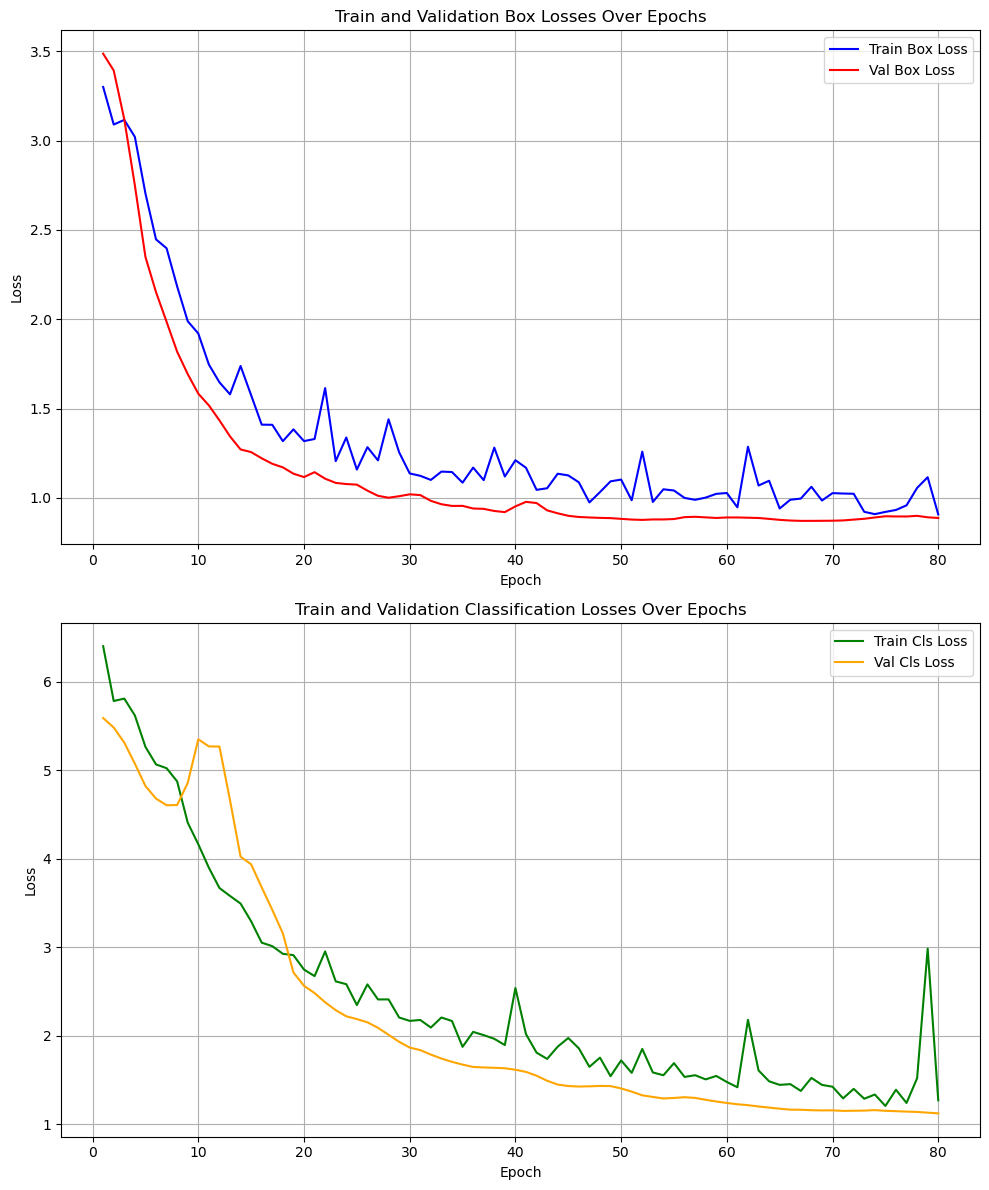

In [10]:
YOLO_RESULTS_FOLDER = './runs/detect/train'

import pandas as pd

df = pd.read_csv(os.path.join(YOLO_RESULTS_FOLDER, 'results.csv'))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

ax1.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
ax1.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train and Validation Box Losses Over Epochs')
ax1.legend()
ax1.grid(True)

ax2.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', color='green')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Train and Validation Classification Losses Over Epochs')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



In [11]:
test_images_path = os.path.join(yolo_data_folder, 'test', 'images')

model_weights = os.path.join(YOLO_RESULTS_FOLDER, 'weights/best.pt')
trained_model = YOLO(model_weights)



image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190821_123648.labeled_512_0.jpg: 640x640 10 1s, 1 3, 9 5s, 10 7s, 3 10s, 1 13, 2 14s, 5 15s, 2 17s, 2 19s, 4 21s, 4 25s, 1 27, 2 29s, 8 30s, 5 37s, 1 50, 1 63, 8.1ms
Speed: 4.0ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


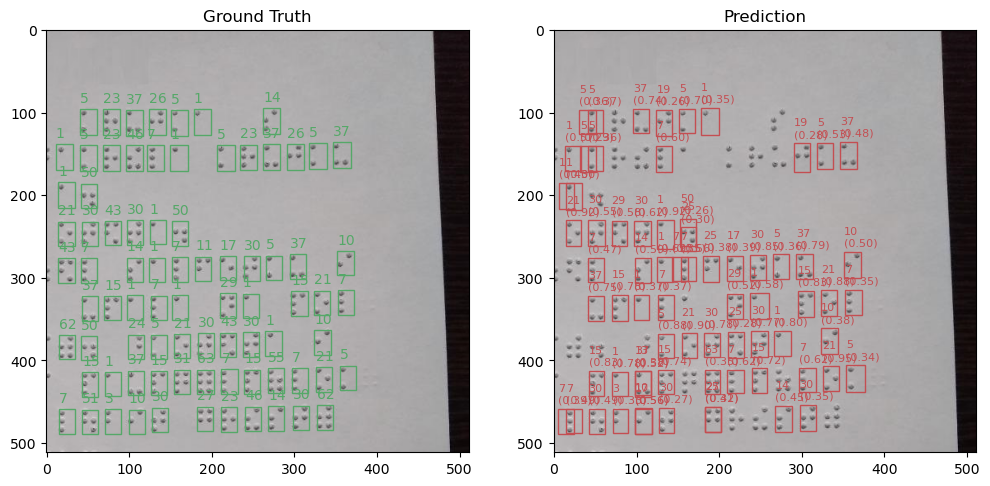


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113010.labeled_512_1024.jpg: 640x640 4 1s, 1 2, 1 7, 2 15s, 1 21, 1 23, 1 46, 2 47s, 1 58, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


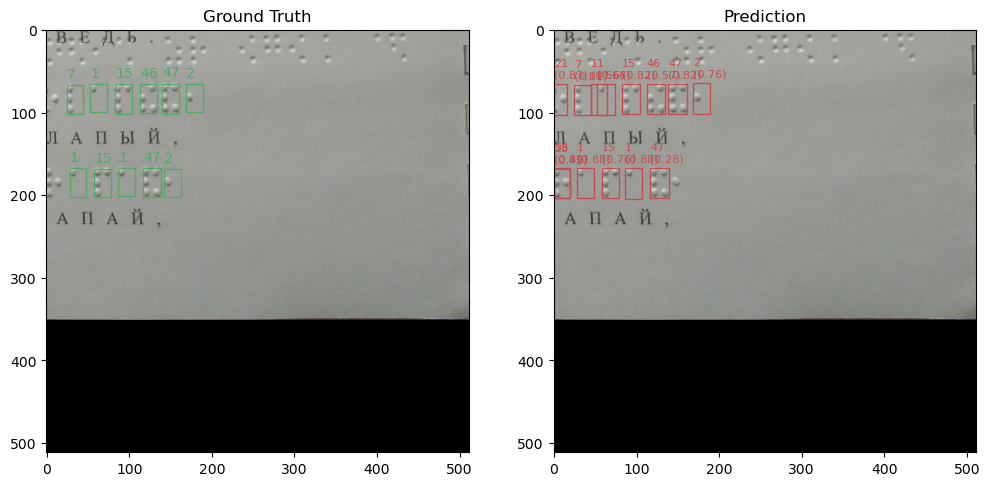


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113010.labeled_512_512.jpg: 640x640 4 1s, 3 5s, 2 7s, 4 10s, 1 13, 6 17s, 1 18, 2 21s, 1 22, 2 23s, 3 25s, 2 30s, 2 58s, 2 62s, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


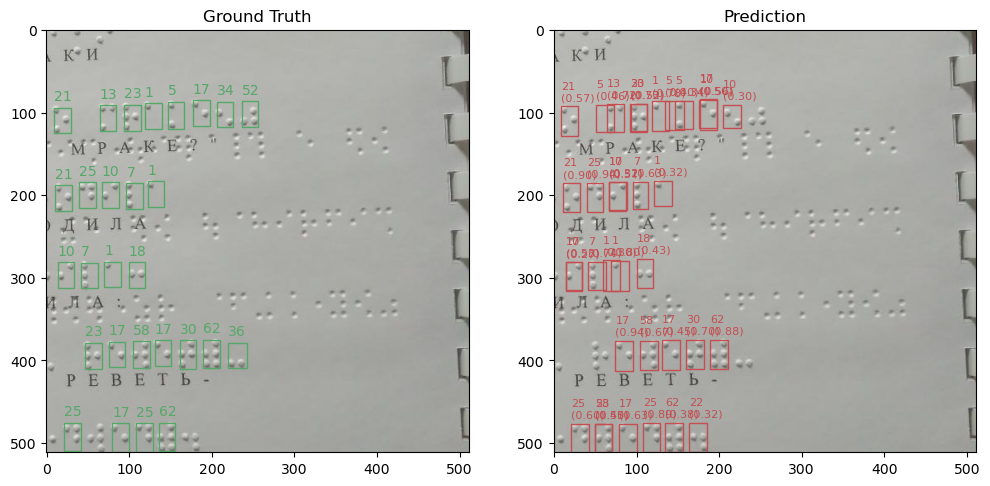


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG-20190315-WA0017_0_0.jpg: 640x640 4 1s, 1 5, 1 7, 1 9, 7 10s, 1 13, 1 14, 12 17s, 1 21, 3 30s, 1 37, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


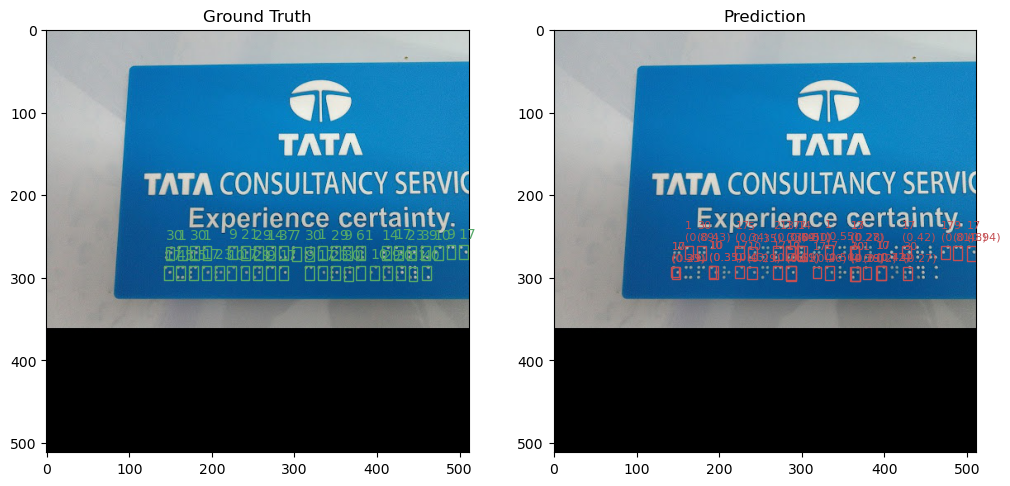


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG-20190420-WA0010_0_0.jpg: 640x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


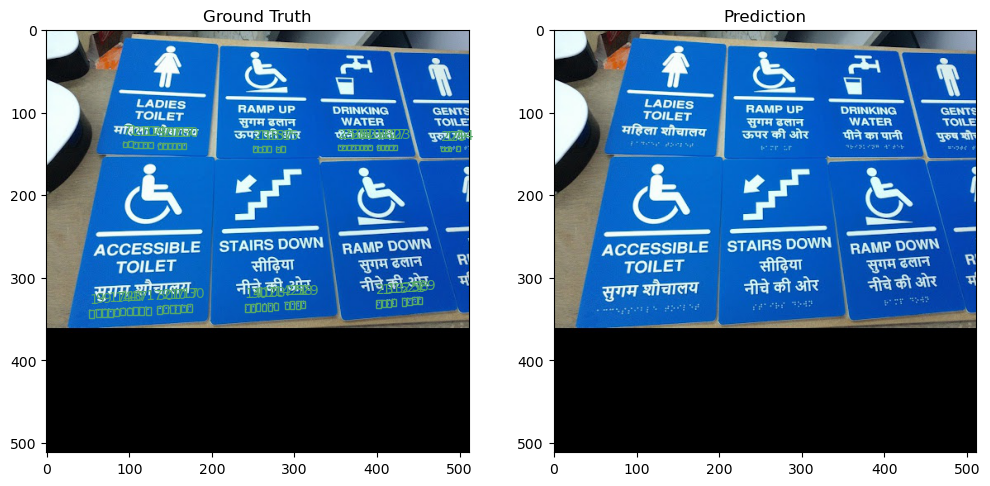

In [12]:
from random import choice

def plot_annotated_images_with_predictions(test_images, trained_model):
    img_file, lbl_file = choice(test_images)
    img_file = os.path.join(yolo_data_folder, 'test', 'images', img_file)
    lbl_file = os.path.join(yolo_data_folder, 'test', 'labels', lbl_file)
    
    img = cv2.imread(img_file)
    
    if img is None:
        print(f"Error: Could not load image {img_file}")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    
    with open(lbl_file, "r") as f:
        ground_truth_boxes = f.readlines()
    
    results = trained_model(img_file)
    predictions = results[0].boxes.xywh.cpu().numpy()
    confidences = results[0].boxes.conf.cpu().numpy()
    class_ids = results[0].boxes.cls.cpu().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(img_rgb)
    ax1.set_title("Ground Truth")
    
    for gt_box in ground_truth_boxes:
        class_id, x_center, y_center, box_width, box_height = map(float, gt_box.strip().split())
        x_center *= width
        y_center *= height
        box_width *= width
        box_height *= height
        x_min = x_center - box_width / 2
        y_min = y_center - box_height / 2
        ax1.add_patch(plt.Rectangle((x_min, y_min), box_width, box_height, edgecolor='g', facecolor='none'))
        ax1.text(x_min, y_min - 5, f"{int(class_id) + 1}", color='g', fontsize=10, verticalalignment='bottom')
    
    ax2.imshow(img_rgb)
    ax2.set_title("Prediction")
    
    for pred_box, confidence, class_id in zip(predictions, confidences, class_ids):
        x_center, y_center, width_pred, height_pred = pred_box
        
        x_min = x_center - width_pred / 2
        y_min = y_center - height_pred / 2
        
        ax2.add_patch(plt.Rectangle((x_min, y_min), width_pred, height_pred, edgecolor='r', facecolor='none'))
        ax2.text(x_min, y_min - 5, f"{int(class_id) + 1}\n({confidence:.2f})", color='r', fontsize=8, verticalalignment='bottom')
    
    plt.show()

    
for _ in range(5):
    plot_annotated_images_with_predictions(test_images, trained_model)

In [13]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def iou_score(box_a, box_b):
    """Calculate Intersection over Union (IoU) between two bounding boxes."""
    x_min_a, y_min_a, width_a, height_a = box_a
    x_min_b, y_min_b, width_b, height_b = box_b

    x_max_a, y_max_a = x_min_a + width_a, y_min_a + height_a
    x_max_b, y_max_b = x_min_b + width_b, y_min_b + height_b

    inter_x_min = max(x_min_a, x_min_b)
    inter_y_min = max(y_min_a, y_min_b)
    inter_x_max = min(x_max_a, x_max_b)
    inter_y_max = min(y_max_a, y_max_b)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
    area_a = width_a * height_a
    area_b = width_b * height_b

    union_area = area_a + area_b - inter_area
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def evaluate_model(test_images, trained_model, iou_threshold=0.5):
    ious, y_true, y_pred = [], [], []

    for img_file, lbl_file in test_images:
        img_path = os.path.join(yolo_data_folder, 'test', 'images', img_file)
        lbl_path = os.path.join(yolo_data_folder, 'test', 'labels', lbl_file)
        
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Error: Could not load image {img_path}")
            return
        
        height, width, _ = img.shape
        
        with open(lbl_path, "r") as f:
            ground_truth_boxes = [list(map(float, line.strip().split())) for line in f.readlines()]
        
        results = trained_model(img_path)
        predictions = results[0].boxes.xywh.cpu().numpy()
        pred_classes = results[0].boxes.cls.cpu().numpy()
        
        for gt_class, x_center, y_center, box_width, box_height in ground_truth_boxes:
            x_center *= width
            y_center *= height
            box_width *= width
            box_height *= height
            gt_box = [(x_center - box_width / 2), (y_center - box_height / 2), box_width, box_height]
            max_iou, matched_pred_class = 0, -1
            
            for pred_box, pred_class in zip(predictions, pred_classes):
                x_center, y_center, width_pred, height_pred = pred_box
                
                x_min = x_center - width_pred / 2
                y_min = y_center - height_pred / 2
                
                pred_box = [x_min, y_min, width_pred, height_pred]
                
                iou = iou_score(gt_box, pred_box)
                if iou > max_iou:
                    max_iou = iou
                    matched_pred_class = int(pred_class)
            
            ious.append(max_iou)
            y_true.append(int(gt_class))
            y_pred.append(matched_pred_class if max_iou >= iou_threshold else -1)
    
    ious = np.array(ious)
    avg_iou = np.mean(ious)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    return {
        'avg_iou': avg_iou,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

metrics = evaluate_model(test_images, trained_model)



image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190822_182350.labeled_512_512.jpg: 640x640 3 1s, 1 2, 2 5s, 4 7s, 4 10s, 1 14, 3 17s, 2 21s, 2 23s, 2 29s, 1 37, 1 45, 1 50, 2 58s, 1 62, 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113010.labeled_512_512.jpg: 640x640 4 1s, 3 5s, 2 7s, 4 10s, 1 13, 6 17s, 1 18, 2 21s, 1 22, 2 23s, 3 25s, 2 30s, 2 58s, 2 62s, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20210708_132533619_0_0.jpg: 640x640 1 1, 1 7, 1 9, 1 10, 3 14s, 1 17, 2 30s, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/AF1QipOkgsneVSdYeba5vP16itZ79s642g-nPfsEr4hh

#### Evaluation

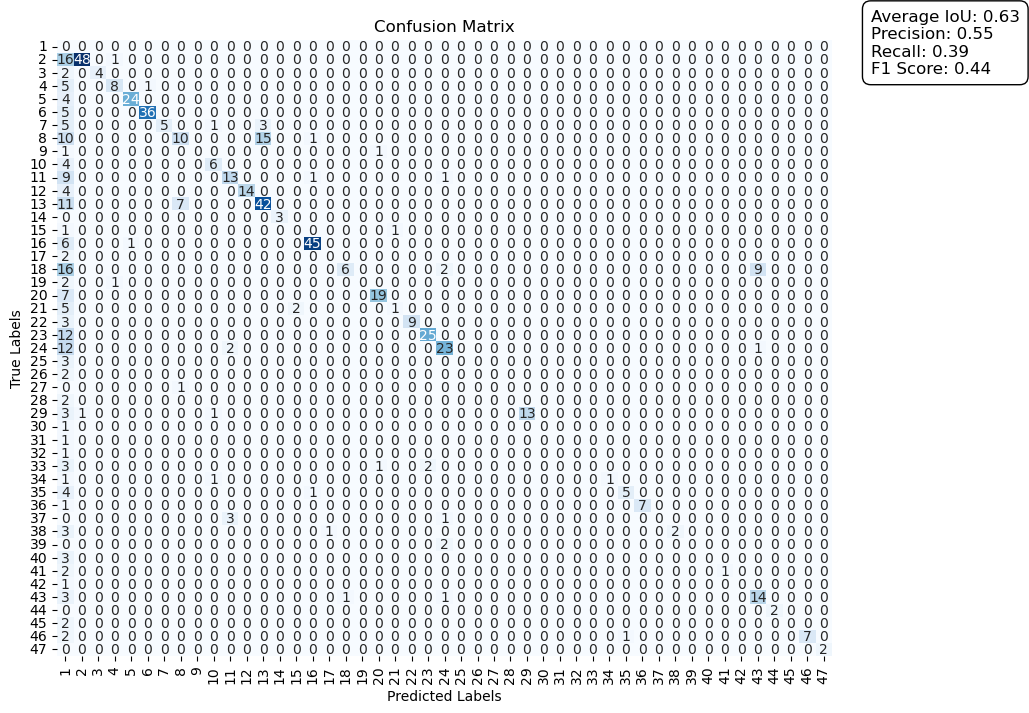

In [14]:
def plot_confusion_matrix(conf_matrix, class_names, metrics):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    
    metrics_text = (
        f"Average IoU: {metrics['avg_iou']:.2f}\n"
        f"Precision: {metrics['precision']:.2f}\n"
        f"Recall: {metrics['recall']:.2f}\n"
        f"F1 Score: {metrics['f1_score']:.2f}"
    )
    
    plt.gca().text(1.05, 1.05, metrics_text, transform=plt.gca().transAxes,
                   fontsize=12, verticalalignment='top',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    plt.show()

class_names = [f"{i + 1}" for i in range(len(metrics['confusion_matrix']))]
plot_confusion_matrix(metrics['confusion_matrix'], class_names, metrics)

### HOUGH TRANSFORM

In [15]:
def HoughTransform(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    
    circles = cv2.HoughCircles(
        blurred, 
        cv2.HOUGH_GRADIENT, 
        dp=1.2,       
        minDist=4,   
        param1=50,    
        param2=30,    
        minRadius=4, 
        maxRadius=50 
    )
    
    output_image = np.zeros_like(gray)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(output_image, (i[0], i[1]), i[2], (255), 2)
    
    return output_image

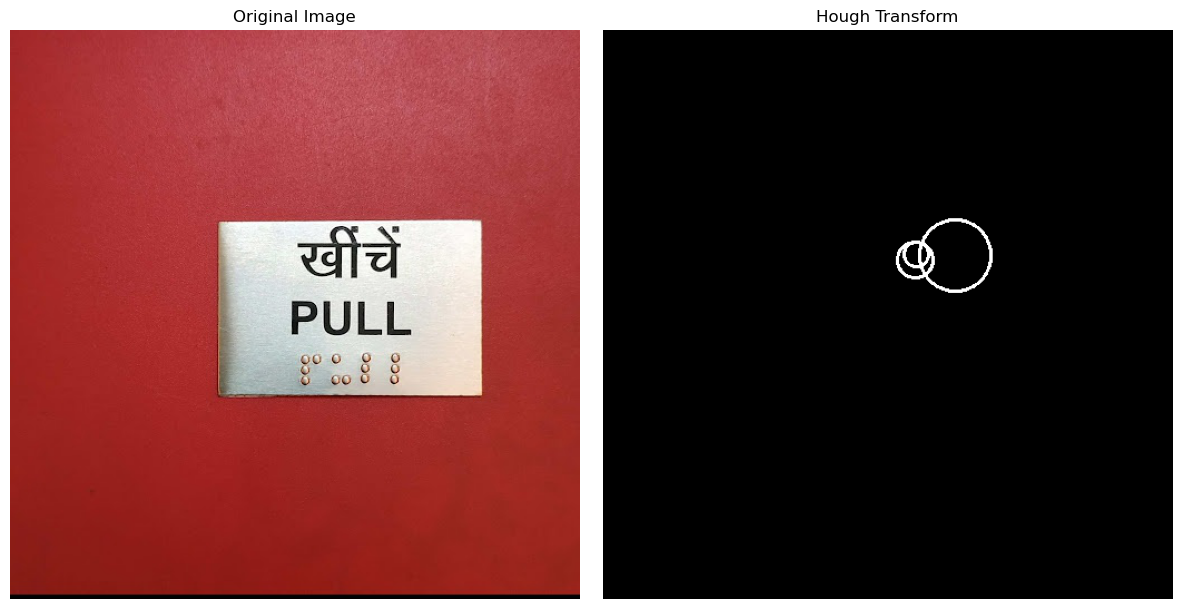

In [16]:
"""
TEST HOUGH TRANSFORM
"""

hough_test_image = './data-yolo/AF1QipOkgsneVSdYeba5vP16itZ79s642g-nPfsEr4h_0_0.jpg'

def test_hough_transform(image_path):
    hough_test_image = cv2.imread(image_path)

    transformed_image = HoughTransform(hough_test_image)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(hough_test_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(transformed_image, cmap='gray')
    plt.title("Hough Transform")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
test_hough_transform(hough_test_image)

### TEXT SPOTTING MODEL

In [17]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out, scale_factor=4):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=scale_factor),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x

In [19]:
"""
Testing Models:
"""

def test_backbone(model, batch_size=16, imgsz=256):
    torch.cuda.empty_cache()
    model.to(device)
    image_tensor = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(image_tensor)
    print("Output shape:", output.shape)

class Backbone(nn.Module):
    """
    YOLO Backbone:
    
    output feature map: (batch_size, 3, 256, 256)
    """
    def __init__(self):
        super(Backbone, self).__init__()
        self.backbone = torch.hub.load("ultralytics/yolov5", "yolov5s").to(device)
        self.grid_size = 256
        
        self.conv1 = nn.Conv1d(4032, 512, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(512, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(128, 3, kernel_size=3, stride=1, padding=1)
        
        self.upsample1 = UpConvBlock(ch_in=3, ch_out=3)
        self.upsample2 = UpConvBlock(ch_in=3, ch_out=3)
        self.upsample3 = UpConvBlock(ch_in=3, ch_out=3, scale_factor=2)
        
        self._freeze_layers()
        
        
    def _freeze_layers(self):
        """
        Freezing the Backbone (except the last layer)
        """
        freeze = [f"model.{x}." for x in range(24)]
        for k, v in self.backbone.named_parameters():
            v.requires_grad = True
            if any(x in k for x in freeze):
                v.requires_grad = False
    
    def forward(self, x):
        """
        Creates an interface for the Backbone
        with output grid size: (batch_size, 3, self.grid_size, self.grid_size)
        """
        backbone_out = self.backbone.model.forward(x) # (batch_size, 4032, 85)
        
        l1 = self.conv1(backbone_out)  # (batch_size, 512, 85)
        l2 = self.conv2(l1)  # (batch_size, 128, 85)
        l3 = self.conv3(l2)  # (batch_size, 3, 85)
        
        l3 = l3.unsqueeze(-1)  # (batch_size, 3, 85, 1)
        
        l4 = self.upsample1(l3) # (batch_size, 3, 340, 4)
        l5 = self.upsample2(l4) # (batch_size, 3, 1360, 16)
        l6 = self.upsample3(l5) # (batch_size, 3, 2720, 32)
        
        out = torch.nn.functional.interpolate(l6, size=(self.grid_size, self.grid_size), mode='bilinear', align_corners=False)
        return out # (batch_size, 3, 256, 256)
    
"""
TEST
"""
test_backbone(Backbone())

Using cache found in /home/zeenx1popos/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-9 Python-3.12.2 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Output shape: torch.Size([16, 3, 256, 256])


In [20]:
"""
Testing Models:
"""

def test_retention(model, x1_channels=512, x2_channels=512, batch_size=16, imgsz=20):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, x1_channels, imgsz, imgsz).to(device)
    layer2 = torch.randn(batch_size, x2_channels, imgsz, imgsz).to(device)
    output = model(layer1, layer2)
    print("Output shape:", output.shape)


class RetentionLayer(nn.Module):
    def __init__(self, x1_channels, x2_channels, out_channels):
        super(RetentionLayer, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(
                in_channels=x1_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                bias=True,
            ),
            nn.BatchNorm2d(out_channels)
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(
                in_channels=x2_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                bias=True,
            ),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(inplace=True)
        self.attention = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=1,
                kernel_size=1,
                stride=1,
                bias=True,
            ),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
        
    def forward(self, X1, X2):
        x1 = self.seq1(X1)
        x2 = self.seq2(X2)
        S = self.relu(x1 + x2)
        S = self.attention(S)
        return X1 * S

"""
TEST
"""
test_retention(RetentionLayer(512, 512, 256))

        

Output shape: torch.Size([16, 512, 20, 20])


In [21]:
"""
Testing Models:
"""

def test_HoughModule(model, batch_size=16, imgsz=512):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(layer1)
    print("Output shape:", output.shape)

class HoughModule(nn.Module):
    def __init__(self):
        super(HoughModule, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=6,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=6,
                      out_channels=3,
                      kernel_size=1),
            nn.SiLU(inplace=True),
        )
    
    def forward(self, image):
        transformed_image = image
        # mask = HoughTransform(image)
        # transformed_image = image * mask
        out = self.seq1(transformed_image)
        return out
    

"""
TEST
"""

test_HoughModule(HoughModule())

Output shape: torch.Size([16, 3, 512, 512])


In [22]:
class PredictBlock(nn.Module):
    def __init__(self) -> None:
        super(PredictBlock, self).__init__()
        
    def forward(x, img):
        return x